In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math

/home/livio/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/livio/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#pi greco
Pi = tf.constant( 3.14159, dtype = tf.float32)
#sigma = 10.
a = tf.constant( 0.5, dtype = tf.float32)
lambdaa = tf.constant( .00035, dtype = tf.float32)
#size of hidden states
state_size = 12
#length of a sequence
size = 10
#total number of samples
num_samples = 2000
#number of samples in a batch (choose a number that divides num_samples)
epoch_size = 50
num_step = int(num_samples/epoch_size)
#number of epochs
num_epochs = 101

In [3]:
def gen_data(size= size, num_samples = num_samples):
    lista = []
    yout = []
    for _ in range(num_samples):
            X = 2*np.random.random(size) - 1
            ar1 = np.zeros(size)
            a = int( np.floor(size*np.random.random()) )      
            ar1[a] = 1.
            segna = True
            while segna:
                b = int( np.floor(size*np.random.random()) )
                if ( b != a):
                    segna = False
            ar1[b] = 1. 
            yout.append(0.5 + 0.25*( X[b] + X[a] ))
            ar2 = np.dstack( (X,ar1)) 
            ar2 = np.squeeze(ar2)
            lista.append(ar2)
    Xout = np.stack(lista, axis=0)  
    y_train = np.asarray(yout)
    y_train = np.reshape(y_train, [num_samples,1])
    return Xout, y_train



In [4]:
def gen_batch(raw_data, epoch_size, num_step):
    raw_x, raw_y = raw_data
    for i in range(num_step):
        x = raw_x[i*epoch_size:(i + 1) * epoch_size, :, :]
        y = raw_y[i*epoch_size:(i + 1) * epoch_size, :]
        yield (x, y)

def gen_epochs(n, epoch_size, num_step):
    for i in range(n):
        yield gen_batch(gen_data(), epoch_size, num_step)        

In [5]:
x = tf.placeholder(tf.float32, [epoch_size, size, 2], name='input_placeholder')
y = tf.placeholder(tf.float32, [epoch_size, 1], name='output_placeholder')
sigma = tf.placeholder(tf.float32, shape = (), name='sigma_placeholder')
#init_state = tf.zeros([num_samples, state_size])

with tf.variable_scope('inizialization'):
    iss = tf.get_variable('iss', [epoch_size, state_size], initializer=tf.constant_initializer(0.0))

rnn_inputs = tf.unstack(x, axis=1)

In [6]:
def conv_h_sigma(tensor):
    #coeff = a/math.sqrt(1. + 2.*math.pow(a*sigma,2.))
    coeff = a/tf.sqrt( 1. + 2.*tf.square(a*sigma) )
    return tf.erf( tf.scalar_mul(coeff, tensor) )

def sqrt_conv_h2_sigma(tensor):
    unos = tf.ones_like(tensor, tf.float32)
    #coeff1 = - math.sqrt(Pi)/math.sqrt(Pi + 8.*math.pow(a*sigma,2.))
    #coeff2 = - (4.*math.pow(a,2.))/( Pi + 8.*math.pow(a*sigma,2.) )
    coeff1 = - tf.sqrt(Pi)/tf.sqrt(Pi + 8.*tf.square(a*sigma))
    coeff2 = - 4.*tf.square(a)/(Pi + 8.*tf.square(a*sigma))
    x2 = tf.exp( tf.scalar_mul(coeff2, tf.multiply(tensor,tensor) ) )
    return tf.sqrt( tf.add( unos, tf.scalar_mul(coeff1,x2)  ) ) 

def square_norm(tensor):
    return tf.reduce_sum( tf.multiply(tensor,tensor) )

In [7]:
with tf.variable_scope('rnn_cell'):
    U = tf.get_variable('U', [2, state_size])
    V = tf.get_variable('V', [state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse= True):
        U = tf.get_variable('U', [2, state_size])
        V = tf.get_variable('V', [state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    parz1 = tf.matmul(rnn_input, U) 
    parz2 = tf.matmul(state, V) 
    fin = tf.add(parz1,parz2) + b
    return conv_h_sigma(fin), sqrt_conv_h2_sigma(fin)

def get_initial_state():
    with tf.variable_scope('inizialization', reuse= True):
        iss = tf.get_variable('iss', [epoch_size, state_size], initializer=tf.constant_initializer(0.0))
    return conv_h_sigma(iss), sqrt_conv_h2_sigma(iss)    
    

In [8]:
"""
Adding rnn_cells to graph

This is a simplified version of the "static_rnn" function from Tensorflow's api. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn.py#L41
Note: In practice, using "dynamic_rnn" is a better choice that the "static_rnn":
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py#L390
"""
#state = init_state
state = get_initial_state()
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state[0])
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

In [9]:
def calulate_initial_contribution(a, sigma):
    with tf.variable_scope('rnn_cell', reuse= True):
        V = tf.get_variable('V', [state_size, state_size])
    iss = get_initial_state()
    term1 = square_norm( tf.matmul( iss[1], V) )
    term2 = square_norm( tf.matmul( iss[0], V) )
    term3 = tf.square(sigma)*state_size*square_norm( iss[0]  )
    return term1 - term2 + term3


### Routine to calculate the real energy

In [10]:
def rnn_cell_real(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse= True):
        U = tf.get_variable('U', [2, state_size])
        V = tf.get_variable('V', [state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    parz1 = tf.matmul(rnn_input, U) 
    parz2 = tf.matmul(state, V) 
    fin = tf.add(parz1,parz2) + b
    return tf.erf(fin)

def get_initial_state_real():
    with tf.variable_scope('inizialization', reuse= True):
        iss = tf.get_variable('iss', [epoch_size, state_size], initializer=tf.constant_initializer(0.0))
    return tf.erf(iss)    

state_real = get_initial_state_real()
rnn_outputs_real = []
for rnn_input in rnn_inputs:
    state_real = rnn_cell_real(rnn_input, state_real)
    rnn_outputs_real.append(state_real)
final_state_real = rnn_outputs_real[-1]

### End part for the real energy

In [11]:
"""
Predictions, loss, training step

Losses is similar to the "sequence_loss"
function from Tensorflow's API, except that here we are using a list of 2D tensors, instead of a 3D tensor. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/loss.py#L30
"""


#logits and predictions
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, 1])
    b = tf.get_variable('b', [1], initializer=tf.constant_initializer(0.0))


prediction = conv_h_sigma((tf.matmul(final_state[0], W) + b) ) 

parz = tf.subtract(prediction,y)
term1 = square_norm(sqrt_conv_h2_sigma(tf.matmul(final_state[1], W) + b ))
term2 = square_norm( conv_h_sigma(tf.matmul(final_state[0], W) + b) ) 

term3 = square_norm( tf.matmul(final_state[1], W )   )
term4 = square_norm( tf.matmul(final_state[0], W )   )
term5 = sigma*sigma*square_norm(final_state[0])

ca = calulate_initial_contribution(a, sigma)


TT = lambdaa*( term3 - term4 + term5 + ca )

total_loss = (tf.reduce_sum(tf.multiply(parz,parz)) + term1 - term2)/(2.*epoch_size) + TT
#####ATTTENZIONE QUI
################### ATTTENZIONE !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
################### ATTENZIONE@!^#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(total_loss)

In [12]:
prediction_real = tf.erf((tf.matmul(final_state_real, W) + b) ) 
parz_real = tf.subtract(prediction_real,y)
total_loss_real = tf.reduce_sum(tf.multiply(parz_real,parz_real))/(2.*epoch_size)

In [13]:
# Initializing the variables
init = tf.global_variables_initializer()
training_state = np.zeros((num_samples, state_size))

# Launch the graph
sigmaV = 6.
listsigma = []
listepochs = []
arrayvalues = []
arrayvalues1 = []
initialiter = True
with tf.Session() as sess:
    sess.run(init)
    while sigmaV > 3.1:
        listsigma.append(sigmaV)
        arrayvaluesparz = []
        arrayvalues1parz = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, epoch_size, num_step)):
            training_loss = 0
            training_loss_real = 0
            if initialiter == True:
                listepochs.append(idx)
            for step, (X, Y) in enumerate(epoch):
                sess.run([optimizer], feed_dict={x: X, y: Y, sigma: sigmaV})
                c = sess.run(total_loss, feed_dict={x: X, y: Y, sigma: sigmaV})
                cr = sess.run(total_loss_real, feed_dict={x: X, y: Y, sigma: sigmaV})
                training_loss += c
                training_loss_real += cr
                if (step == num_step - 1):
                    arrayvaluesparz.append( training_loss/step )
                    arrayvalues1parz.append( training_loss_real/step )
                if idx % 20 == 0:
                    if (step == num_step - 1):
                        print( "average cost=", "{:.4f}".format(training_loss/step), 
                               "average cost real=", "{:.4f}".format(training_loss_real/step)  )
        arrayvalues.append(arrayvaluesparz)
        arrayvalues1.append(arrayvalues1parz)            
        initialiter = False                
        sigmaV = sigmaV*0.91
        print('###################')
        print('SIGMAV = ', sigmaV)

       

average cost= 0.7465 average cost real= 0.3142
average cost= 0.6688 average cost real= 0.2810
average cost= 0.6187 average cost real= 0.2500
average cost= 0.5956 average cost real= 0.2255
average cost= 0.5753 average cost real= 0.1897
average cost= 0.5574 average cost real= 0.1629
###################
SIGMAV =  5.46
average cost= 0.5470 average cost real= 0.1624
average cost= 0.5373 average cost real= 0.1320
average cost= 0.5293 average cost real= 0.1115
average cost= 0.5252 average cost real= 0.0922
average cost= 0.5209 average cost real= 0.0827
average cost= 0.5153 average cost real= 0.0723
###################
SIGMAV =  4.9686
average cost= 0.5039 average cost real= 0.0743
average cost= 0.4987 average cost real= 0.0651
average cost= 0.4893 average cost real= 0.0636
average cost= 0.4880 average cost real= 0.0693
average cost= 0.4800 average cost real= 0.0761
average cost= 0.4789 average cost real= 0.0754
###################
SIGMAV =  4.521426000000001
average cost= 0.4565 average cost 

In [14]:
aa = np.asarray(arrayvalues)
bb = np.asarray(arrayvalues1)
print(aa.shape)

(8, 101)


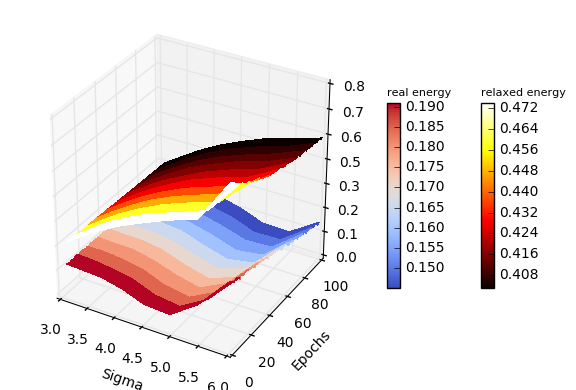

In [52]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()
ax = fig.gca(projection='3d')


X = np.asarray(listsigma)
Y = np.asarray(listepochs)
Y, X = np.meshgrid(Y, X)


# Plot the surface.
surf = ax.plot_surface( X,Y, aa, cmap=cm.hot,
                       linewidth=0, antialiased=False)

surf1 = ax.plot_surface( X,Y, bb, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

#ax.set_zlim(.02, .81)
ax.zaxis.set_major_locator(LinearLocator(8))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.01f'))
ax.set_xlabel('Sigma')
ax.set_ylabel('Epochs')


clb = fig.colorbar(surf, shrink=0.5, aspect=15)
clb1 = fig.colorbar(surf1, shrink=0.5, aspect=15)

clb.ax.set_title('relaxed energy', loc='left', fontsize = 8)
clb1.ax.set_title('real energy', loc='left', fontsize = 8)
fig.tight_layout()



plt.show()
fig.savefig('foo.png')